# 2.2 ICESat-2 data frame plotting
### taken out of 2.3

In [2]:
import importlib
lib_loader = importlib.find_loader('cartopy')

if lib_loader is not None:
    REBUILD_CONDA_ENV = False
    print("No need to re-build conda env.")
else:
    REBUILD_CONDA_ENV = True
    print("Re-build conda env...")

if REBUILD_CONDA_ENV:
    #### This notebook uses a DPS job to run extract_atl08.py to convert h5's to csv's, then appends all csv's into a pandas geodataframe.
    #### Returns: a pandas geodataframe that should hold the entire set of ATL08 data for this project
    #### Notes:
    ###### ISSUE: how to relaibly activate a conda env that can support this notebook.
    ###### Need to 'conda activate' an env that has geopandas - but where do I do this 'activate'. How does terminal env interact with nb?
    ###### Workaround: always do this to base:
    ! conda install -c conda-forge geopandas -y
    #! conda install -c conda-forge cartopy -y
    ! conda install -c conda-forge descartes -y
    ! conda install -c conda-forge seaborn -y
    ! conda install contextily --channel conda-forge -y
    #! conda install -c conda-forge matplotlib_scalebar -y

import geopandas as gpd
import descartes
import numpy as np
import seaborn as sb
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd
import glob
import os
import random 
import shutil
import time
import math

import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import datetime
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

Re-build conda env...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Deprecated since Python 3.4. Use importlib.util.find_spec() instead.
  


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [28]:
import sys
sys.path.append('/projects/code/icesat2_boreal/notebooks/3.Gridded_product_development')
from CovariateUtils import *

import FilterUtils
import ExtractUtils


from importlib import reload 
reload(FilterUtils)

DIR_PICKLE = '/projects/jabba/data'

print("Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...")
print("----THIS IS FILTERED WITH AN OLD SET OF FILTERS")
list_of_pickles = glob.glob(DIR_PICKLE+'/atl08_filt*.pkl') # * means all if need specific format then *.csv
latest_pickle_file = max(list_of_pickles, key=os.path.getctime)
print(latest_pickle_file)
atl08 = pd.read_pickle(latest_pickle_file)
print("ATL08 db now available from pickled file.")

# Filter by quality
atl08 = FilterUtils.filter_atl08_qual(atl08, SUBSET_COLS=True, 
                                                   subset_cols_list=['rh25','rh50','rh60','rh70','rh75','rh80','rh85','rh90','rh95','h_can','h_max_can','night_flg','yr','m','n_toc_ph'], 
                                                   filt_cols=['h_can','h_dif_ref','m','msw_flg','beam_type','seg_snow'], 
                                                   thresh_h_can=100, thresh_h_dif=100, month_min=6, month_max=9)

Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...
----THIS IS FILTERED WITH AN OLD SET OF FILTERS
/projects/jabba/data/atl08_filt_20210302212944.pkl
ATL08 db now available from pickled file.

Pre-filter data cleaning...

Get beam type from orbit orientation and ground track...
['Strong']
Cast some columns to type float: ['lat', 'lon', 'h_can', 'h_te_best', 'ter_slp']
Cast some columns to type integer: ['n_ca_ph', 'n_seg_ph', 'n_toc_ph']

Filtering for quality:
	for clear skies + strong beam + snow free land,
	h_can < 100,
	elevation diff from ref < 100,
	months 6-9
Before quaity filtering: 1489001 observations in the input dataframe.
After quality filtering: 1412546 observations in the output dataframe.
Returning a pandas data frame of filtered observations for columns: ['lon', 'lat', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95', 'h_can', 'h_max_can', 'night_flg', 'yr', 'm', 'n_toc_ph']
Shape: (1412546, 17) 


# of ATL08 columns:  17
There are 1412546 observations in this dataframe.
Max lat: 80.00273895263672
Min lat: 40.00008773803711
Max lon: 179.43710327148438
Min lon: -179.6292266845703
Years:  [2019 2020]
Months:  [8 6 9 7]

Example 1: Get only clear sky data, by year, with ht threshold.

There are 840051 observations in day.

There are 572495 observations in night.


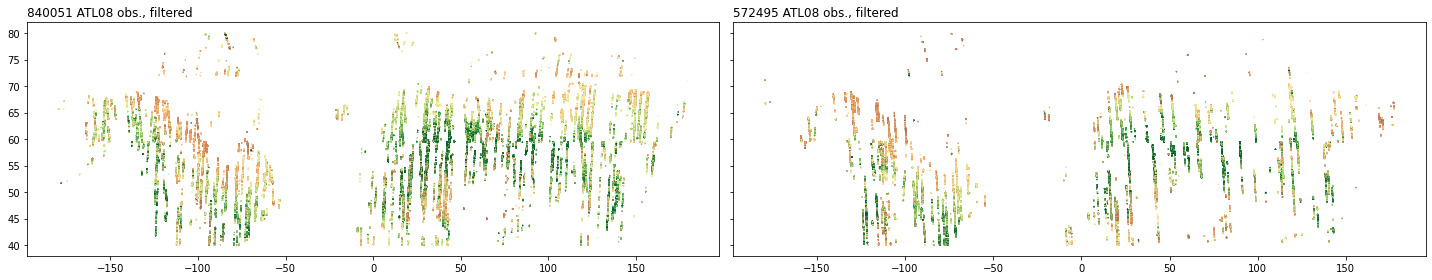

In [29]:
# Exploring filtered ATL08 with plots
print("# of ATL08 columns: ", len(atl08.columns))
print(f"There are {atl08.shape[0]} observations in this dataframe.")
#print("Col names: ", atl08.columns)
print("Max lat:",    atl08.lat.max())
print("Min lat:",    atl08.lat.min())
print("Max lon:",    atl08.lon.max())
print("Min lon:",    atl08.lon.min())
print("Years: ",     atl08.yr.unique())
print("Months: ",    atl08.m.unique())

# Plot obs from night and day
# My cmap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

print("\nExample 1: Get only clear sky data, by year, with ht threshold.")

fig, axes = plt.subplots(nrows=1, ncols=atl08.night_flg.nunique(), figsize=(20, 4), sharex=False, sharey=True)
#ax0, ax1, ax2, ax3 = axes.flatten()

SAMP_FRAC = 1 # Map just a portion of the data for speed

i=0
for group_name, group in atl08.groupby('night_flg'):
    print(f"\nThere are {len(group)} observations in {group_name}.")
    #print(f"Filtering for clear skies and h_can < 60")
    #group_tmp = group[ 
    #                  (group.seg_snow == 'snow free land') 
    #                 ].sample(frac=SAMP_FRAC)

    #prop_of_df = round(len(group_tmp) / len(atl08), 3)

    #print(f"Proportion of {group_name} total satifying this filter: {prop_of_df}")
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    scat = axes[i].scatter(x=group.lon, y=group.lat, c=group['h_can'], cmap = forest_ht_cmap, vmin=0, vmax=25, s=0.05)
    #subplt = group.plot(ax=axes[i], x='lon', y='lat', c='h_can', cmap = forest_ht_cmap, vmin=0, vmax=25, kind='scatter', s=0.05) # 
    #axes[i].set_title(str(len(group))+" ATL08 obs. during "+group_name+"\nstrong beam, clear skies, snow-free land, h_can<"+str(H_CAN_THRESH)+", "+group_name
    axes[i].set_title(str(len(group))+" ATL08 obs., filtered"
                      #+"\n"+str(round(prop_of_df*100,1)) +"% of data"
                      , loc='left')
    #cbar = plt.colorbar(scat, extend='max', spacing='proportional', orientation='vertical', shrink=0.7, format="%.0f")
    #cbar.set_label(label = 'Canopy height (m)', size=16)

    i+=1

plt.tight_layout()


1412546


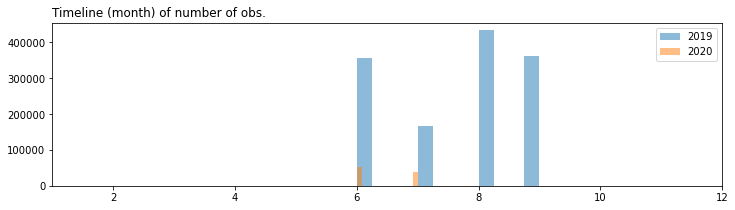

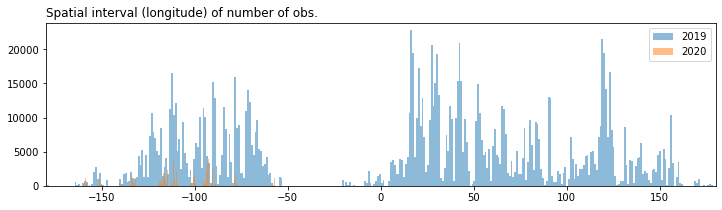

In [30]:
# Simple histogram plotting is **ridiculously** hard to get correct.
#
# here, i try to plot a timeline of the count of ATL08, by day and month, for each year.
f, ax = plt.subplots(1,1,figsize=(12,3))
#atl08['fid'].groupby([atl08["date"].dt.year, atl08["date"].dt.month, atl08["date"].dt.day]).count().plot(ax=ax, kind='bar')

df = atl08.sample(frac=1)
print(len(df))
for i, seg_name in enumerate(df.yr.unique()):
    #ax.hist(atl08[atl08.yr == seg_name].groupby([atl08["date"].dt.month, atl08["date"].dt.day]), bins=bins, alpha=0.5, label=seg_name)
    ax.hist(df[df.yr == seg_name].m, bins=12, alpha=0.5, label=seg_name)
    ax.set_title(f"Timeline (month) of number of obs.", loc='left')
    ax.legend()
    ax.set_xlim(1, 12)
f, ax = plt.subplots(1,1,figsize=(12,3)) 
for i, seg_name in enumerate(df.yr.unique()):
    #ax.hist(atl08[atl08.yr == seg_name].groupby([atl08["date"].dt.month, atl08["date"].dt.day]), bins=bins, alpha=0.5, label=seg_name)
    ax.hist(df[df.yr == seg_name].lon, bins=360, alpha=0.5, label=seg_name)
    ax.set_title(f"Spatial interval (longitude) of number of obs.", loc='left')
    ax.legend()
    ax.set_xlim(-180, 180)

if False:
    # Good luck with getting this plot...
    f, ax = plt.subplots(2,1,figsize=(12,3), sharex=True, sharey=True)
    i=0
    for group_name, group in atl08.groupby('yr'):
        group['m'].groupby([group["date"].dt.month, group["date"].dt.day]).count().plot(ax=ax[i], kind='bar')
        ax[i].set_title(group_name, 
                        loc='left')
        i+=1
#plt.xlabel('Date', fontsize=12)
#plt.xticks(fontsize=7, rotation=90)

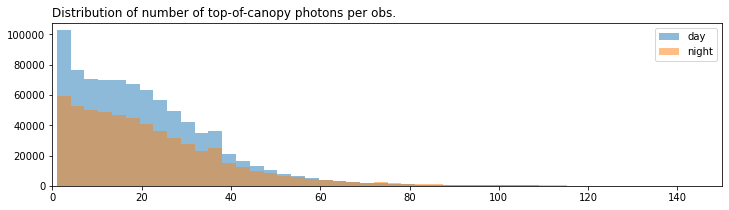

In [31]:
if 'n_toc_ph' in atl08.columns:
    # Use the same bins for each
    xmin = atl08.n_toc_ph.min()
    xmax = atl08.n_toc_ph.max()
    bins = np.linspace(xmin, xmax, 300)

    # Set up correct number of subplots, space them out. 
    fig, ax = plt.subplots(figsize=(12,3))

    for i, seg_name in enumerate(atl08.night_flg.unique()):
        ax.hist(atl08[atl08.night_flg == seg_name].n_toc_ph, bins=bins, alpha=0.5, label=seg_name)
        ax.set_title("Distribution of number of top-of-canopy photons per obs.", loc='left')
        ax.legend()

    # same xlim for each so we can see differences
    ax.set_xlim(0, 150)

In [32]:
# CREATE GEOPANDAS DATAFRAME WITH SPATIAL REF and sample a fractions of it.
#
SAMP_FRAC=1
atl08_gdf = GeoDataFrame(atl08, geometry=gpd.points_from_xy(atl08.lon, atl08.lat), crs='epsg:4326').sample(frac=SAMP_FRAC)

atl08 = None

print(f"There are {atl08_gdf.shape[0]} ATL08 observations in this sampled ({100*SAMP_FRAC}%) Geodataframe.")
print(len(atl08_gdf.columns))
xmin, ymin, xmax, ymax = atl08_gdf.total_bounds

if False:
    # Subset to save for testing
    bbox_sub = [-102.7684,40,-97,32037,47.48166]
    atl08_gdf_sub = atl08_gdf.cx[bbox_sub[0]:bbox_sub[2], bbox_sub[1]:bbox_sub[3]]

    atl08_gdf_sub.to_csv(os.path.split(CSV_TO_DIR)[0]+"/atl08_gdf_sub.csv", index=False, encoding="utf-8-sig")

There are 1412546 ATL08 observations in this sampled (100%) Geodataframe.
18


## Plot Filtered ICESat-2 Data for Domain

In [33]:
# Define a projection for the maps and the geodataframe

# Compare two equal area prjs
# https://map-projections.net/compare.php?p1=albers-equal-area-conic&p2=azimutal-equal-area-gpolar

# These albers prjs dont split the continents polygon well.
# boreal albers projection
#boreal_alb = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-170 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
#na_alb =     "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-110 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"


# https://proj.org/operations/projections/stere.html
boreal_stero = "+proj=stere +lat_0=90 +lat_ts=71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

# https://proj.org/operations/projections/laea.html
northpole_laea = "+proj=laea +lat_0=60 +lon_0=-180 +x_0=90 +y_0=0 +ellps=GRS80" # +datum=NAD83 +units=m +no_defs"

proj = northpole_laea

#if atl08_gdf.lon.min() < 0:
#    proj_alb = boreal_alb

# Clip world to ATL08 gdf
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_atl08 = world.cx[xmin:xmax, ymin:ymax]
atl08_gdf_chull = atl08_gdf.unary_union.convex_hull

world_atl08 = world[world.intersects(atl08_gdf_chull)]
#NA = world[world['continent'] == 'North America'].to_crs(boreal_alb)

atl08_gdf_aea = atl08_gdf.to_crs(proj)
world_atl08_aea = world_atl08.to_crs(proj)

### Clean up workspace to free memory

In [34]:
world_atl08 = None
atl08_gdf = None
atl08_gdf_chull = None

/projects/jabba/data/atl08_alb_h_can_2019_2020_2021Jun17.png


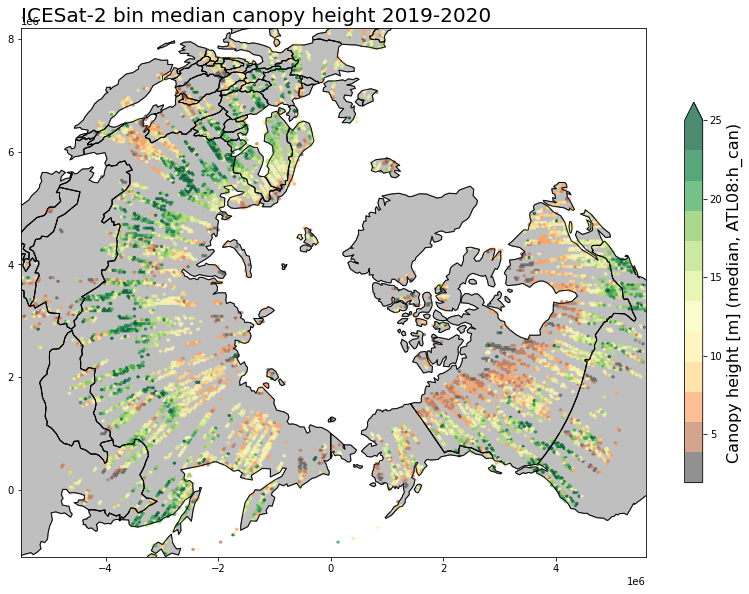

In [35]:
# Exploring ATL08 with hexbins
# All years
ax_map_title = "ICESat-2 bin median canopy height "
cbar_map_title = 'Canopy height [m] (median, ATL08:h_can)'

d = datetime.date.today().strftime("%Y%b%d")
# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(1,1, figsize=(14,10), sharex=True, sharey=True)

bbox = atl08_gdf_aea.total_bounds

atl08_gdf_aea

world_atl08_aea.plot(ax=ax, facecolor='grey', edgecolor='black',  alpha=0.5)
hb = ax.hexbin(atl08_gdf_aea.geometry.x, atl08_gdf_aea.geometry.y, C=atl08_gdf_aea['h_can'], 
                   reduce_C_function=np.median, gridsize=250, cmap=forest_ht_cmap, vmax=25, mincnt=1, alpha=0.7)
world_atl08_aea.plot(ax=ax, facecolor='None', edgecolor='black',  alpha=0.9)

cbar = plt.colorbar(hb, extend='max', spacing='proportional', orientation='vertical', shrink=0.7, format="%.0f")
cbar.set_label(label = cbar_map_title, size=16)
   
ax.set_xlim(bbox[[0,2]])
ax.set_ylim(bbox[[1,3]])
ax.set_title(ax_map_title+"2019-2020", size=20, loc='left')
#ax.grid()
fig_fn = os.path.join(DIR_PICKLE, 'atl08_alb_h_can_2019_2020_'+d+'.png')
print(fig_fn)
#plt.savefig(fig_fn)

#ax.set(aspect='equal')

In [ ]:
print(ctx.providers.keys())
print(ctx.providers.Stamen.keys())

In [ ]:
# Exploring ATL08 with hexbins

def add_basemap(ax, crs, zoom='auto'):
    ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.Stamen.TerrainBackground, zoom=zoom) # ctx.sources.ST_TERRAIN
    #Create a scalebar object, with scaling factor of 1.0 px, since we're using projected coordinate system with unit 1 m
    #scalebar = ScaleBar(1.0)
    #Add scalebar to axes
    #ax.add_artist(scalebar)

bbox = atl08_gdf_aea.total_bounds

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(ncols=atl08_gdf_aea.yr.nunique(), figsize=(30,10), sharex=True, sharey=True)

print(f"Filtering by year for clear skies")
for i, (lab, group) in enumerate(atl08_gdf_aea.groupby('yr')):
    
    world_atl08_aea.plot(ax=ax[i], facecolor='grey', edgecolor='black',  alpha=0.5)
    
    
    hb = ax[i].hexbin(atl08_gdf_aea.geometry.x, atl08_gdf_aea.geometry.y, C=atl08_gdf_aea['h_can'], reduce_C_function=np.median, gridsize=60, cmap=forest_ht_cmap, vmax=30, mincnt=1, alpha=0.7)
    
    #world_atl08_aea.plot(ax=ax[i], facecolor='None', edgecolor='black',  alpha=0.9)
    
    ax[i].set_xlim(bbox[[0,2]])
    ax[i].set_ylim(bbox[[1,3]])
    #ax[i].set_title(ax_map_title+lab, size=20, loc='left')
    #ax[i].grid()
    ax[i].set(aspect='equal')
    add_basemap(ax[i], crs=proj)
    
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.5])
#cbar = fig.colorbar(hb, cax=cbar_ax)
#fig.colorbar(im, ax=axes.ravel().tolist())
cbar = plt.colorbar(hb, ax=ax.ravel().tolist(), extend='max', spacing='proportional', orientation='vertical', shrink=1, format="%.0f")
cbar.set_label(label = cbar_map_title, size=14)
#plt.tight_layout() 

Filtering by year for clear skies


In [ ]:
# Get a DEM for study domain
import os
import requests
import rasterio as rio
from rasterio import plot

#bbox_ll = [-150, 55, -115, 70]
#demtype = "SRTMGL3"
#url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff".format(demtype,*bbox_ll)
#response = requests.get(url)
#src = rio.open(response.content)